# Lab 4: Data Imputation using an Autoencoder

**Deadline**: Sunday, June 16, 9pm

**Late Penalty**: There is a penalty-free grace period of one hour past the deadline. Any work that is submitted between 1 hour and 24 hours past the deadline will receive a 20% grade deduction. No other late work is accepted. Quercus submission time will be used, not your local computer time. You can submit your labs as many times as you want before the deadline, so please submit often and early.

**TA**: Huan Ling

In this lab, you will build and train an autoencoder to impute (or "fill in") missing data. 

We will be using the
Adult Data Set provided by the UCI Machine Learning Repository [1], available 
at https://archive.ics.uci.edu/ml/datasets/adult.
The data set contains census record files of adults, including their
age, martial status, the type of work they do, and other features. 

Normally, people use this data set to build a supervised classification
model to classify whether a person is a high income earner.
We will not use the dataset for this original intended purpose.

Instead, we will perform the task of imputing (or "filling in") missing values in the dataset. For example,
we may be missing one person's martial status, and another person's age, and
a third person's level of education. Our model will predict the missing features 
based on the information that we do have about each person.

We will use a variation of a denoising autoencoder to solve this data imputation
problem. Our autoencoder will be trained using inputs that have one categorical feature artificially
removed, and the goal of the autoencoder is to correctly reconstruct all features,
including the one removed from the input.

In the process, you are expected to learn to:

1. Clean and process continuous and categorical data for machine learning.
2. Implement an autoencoder that takes continuous and categorical (one-hot) inputs.
3. Tune the hyperparameters of an autoencoder.
4. Use baseline models to help interpret model performance.

[1] Dua, D. and Karra Taniskidou, E. (2017). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.


### What to submit

Submit a PDF file containing all your code, outputs, and write-up. You can produce a PDF of your Google Colab file by going to File > Print and then save as PDF. The Colab instructions have more information.

Do not submit any other files produced by your code.

Include a link to your colab file in your submission.


## Colab Link

Include a link to your Colab file here. If you would like the TA to look at your
Colab file in case your solutions are cut off, **please make sure that your Colab
file is publicly accessible at the time of submission**.

Colab Link:https://colab.research.google.com/drive/14mWMcL46ojKV9ek6nXcKimwqo7tbC5N_

In [0]:
import csv
import numpy as np
import random
import torch
import torch.utils.data


import matplotlib.pyplot as plt

## Part 0

We will be using a package called `pandas` for this assignment. 

If you are using Colab, `pandas` should already be available.
If you are using your own computer,
installation instructions for `pandas` are available here: 
https://pandas.pydata.org/pandas-docs/stable/install.html

In [0]:
import pandas as pd

# Part 1. Data Cleaning [15 pt]

The adult.data file is available at `https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data`

The function `pd.read_csv` loads the adult.data file into a pandas dataframe.
You can read about the pandas documentation for `pd.read_csv` at
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html

In [0]:
header = ['age', 'work', 'fnlwgt', 'edu', 'yredu', 'marriage', 'occupation',
 'relationship', 'race', 'sex', 'capgain', 'caploss', 'workhr', 'country']
df = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
    names=header,
    index_col=False)

In [0]:
df.shape # there are 32561 rows (records) in the data frame, and 14 columns (features)

(32561, 14)

### Part (a) Continuous Features [3 pt]

For each of the columns `["age", "yredu", "capgain", "caploss", "workhr"]`, report the minimum, maximum, and average value across the dataset. 

Then, normalize each of the features `["age", "yredu", "capgain", "caploss", "workhr"]`
so that their values are always between 0 and 1.
Make sure that you are actually modifying the dataframe `df`. 

Like numpy arrays and torch tensors, 
pandas data frames can be sliced. For example, we can
display the first 3 rows of the data frame (3 records) below.

In [0]:
df[:3] # show the first 3 records

,age,work,fnlwgt,edu,yredu,marriage,occupation,relationship,race,sex,capgain,caploss,workhr,country
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States


Alternatively, we can slice based on column names, 
for example `df["race"]`, `df["hr"]`, or even index multiple columns 
like below.

In [0]:
subdf = df[["age", "yredu", "capgain", "caploss", "workhr"]]
subdf[:3] # show the first 3 records

,age,yredu,capgain,caploss,workhr
0,39,13,2174,0,40
1,50,13,0,0,13
2,38,9,0,0,40


Numpy works nicely with pandas, like below:

In [0]:
np.sum(subdf["caploss"])

2842700

Just like numpy arrays, you can modify
entire columns of data rather than one scalar element at a time.
For example, the code  

`df["age"] = df["age"] + 1` 

would increment everyone's age by 1.

In [0]:
#find max and min values for each specified index
#store in 2 1 by 5 array
title=["age", "yredu", "capgain", "caploss", "workhr"]
minn=[]
maxx=[]
for i in range(len(title)):
  maxx.append(np.amax(df[title[i]]))
  minn.append(np.amin(df[title[i]]))

#normalize using (x-min)/(max-min)
for i in range(len(title)):
  df[title[i]]=(df[title[i]]-minn[i])/(maxx[i]-minn[i])


### Part (b) Categorical Features [1 pt]

What percentage of people in our data set are male? Note that the data labels all have an unfortunate space in the beginning, e.g. " Male" instead of "Male".

What percentage of people in our data set are female?

In [0]:
# hint: you can do something like this in pandas
sum(df["sex"] == " Male")
print("Male: ",sum(df["sex"] == " Male")/len(df["sex"]))
print("Female: ",sum(df["sex"] == " Female")/len(df["sex"]))
#66.92% of the dataset is Male
#33.08% of the dataset is Female 

Male:  0.6692054912318418
Female:  0.33079450876815825


### Part (c) [2 pt]

Before proceeding, we will modify our data frame in a couple more ways:

1. We will restrict ourselves to using a subset of the features (to simplify our autoencoder)
2. We will remove any records (rows) already containing missing values, and store them in a second dataframe. We will only use records without missing values to train our autoencoder.

Both of these steps are done for you, below.

How many records contained missing features? What percentage of records were removed?

In [0]:
contcols = ["age", "yredu", "capgain", "caploss", "workhr"]
catcols = ["work", "marriage", "occupation", "edu", "relationship", "sex"]
features = contcols + catcols
df = df[features]

In [0]:
missing = pd.concat([df[c] == " ?" for c in catcols], axis=1).any(axis=1)
df_with_missing = df[missing]
df_not_missing = df[~missing]

In [0]:
#find amount of records missing features and percentage
print("Total df:", len(df))
print("Total df & missing:",len(df_with_missing))
print("Total df without missing:",len(df_not_missing))
print("Percentage of recorded removed", len(df_with_missing)/len(df))
#5.66% removed


Total df: 32561
Total df & missing: 1843
Total df without missing: 30718
Percentage of recorded removed 0.056601455729246644


### Part (d) One-Hot Encoding [1 pt]

What are all the possible values of the feature "work" in `df_not_missing`? You may find the Python function `set` useful.

In [0]:
value_w={""}
for i in range(len(df)):
  temp={df["work"][i]}.difference(value_w)
  value_w=value_w.union(temp)
value_w.remove('')
value_w.remove(" ?")

print(value_w)


#Therefore the values of the feature "work" are
#{' State-gov', ' Federal-gov', ' Never-worked', ' Self-emp-not-inc', ' Self-emp-inc', ' Private', ' Without-pay', ' Local-gov'}

{' Self-emp-inc', ' Without-pay', ' Never-worked', ' State-gov', ' Local-gov', ' Private', ' Federal-gov', ' Self-emp-not-inc'}


We will be using a one-hot encoding to represent each of the categorical variables.
Our autoencoder will be trained using these one-hot encodings.

We will use the pandas function `get_dummies` to produce one-hot encodings
for all of the categorical variables in `df_not_missing`. 

In [0]:
data = pd.get_dummies(df_not_missing)

In [0]:
data[:3]

,age,yredu,capgain,caploss,workhr,work_ Federal-gov,work_ Local-gov,work_ Private,work_ Self-emp-inc,work_ Self-emp-not-inc,work_ State-gov,work_ Without-pay,marriage_ Divorced,marriage_ Married-AF-spouse,marriage_ Married-civ-spouse,marriage_ Married-spouse-absent,marriage_ Never-married,marriage_ Separated,marriage_ Widowed,occupation_ Adm-clerical,occupation_ Armed-Forces,occupation_ Craft-repair,occupation_ Exec-managerial,occupation_ Farming-fishing,occupation_ Handlers-cleaners,occupation_ Machine-op-inspct,occupation_ Other-service,occupation_ Priv-house-serv,occupation_ Prof-specialty,occupation_ Protective-serv,occupation_ Sales,occupation_ Tech-support,occupation_ Transport-moving,edu_ 10th,edu_ 11th,edu_ 12th,edu_ 1st-4th,edu_ 5th-6th,edu_ 7th-8th,edu_ 9th,edu_ Assoc-acdm,edu_ Assoc-voc,edu_ Bachelors,edu_ Doctorate,edu_ HS-grad,edu_ Masters,edu_ Preschool,edu_ Prof-school,edu_ Some-college,relationship_ Husband,relationship_ Not-in-family,relationship_ Other-relative,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,sex_ Female,sex_ Male
0,0.301370,0.800000,0.02174,0.0,0.397959,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1
1,0.452055,0.800000,0.00000,0.0,0.122449,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1
2,0.287671,0.533333,0.00000,0.0,0.397959,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1


### Part (e) One-Hot Encoding [2 pt]

The dataframe `data` contains the cleaned and normalized data that we will use to train our denoising autoencoder.

How many **columns** (features) are in the dataframe `data`?

Briefly explain where that number come from.

In [0]:
print(data.shape)


#The number of columns (features) in the dataframe is 57
#This number comes from the values of features that don't have a continous number values
#being represented in seperate one hot incodings. This is in addition to the normalized
#continuous number valued features.

(30718, 57)


### Part (f) One-Hot Conversion [3 pt]

We will convert the pandas data frame `data` into numpy, so that
it can be further converted into a PyTorch tensor.
However, in doing so, we lose the column label information that
a panda data frame automatically stores.

Complete the function `get_categorical_value` that will return
the named value of a feature given a one-hot embedding.
You may find the global variables `cat_index` and `cat_values`
useful. (Display them and figure out what they are first.)

We will need this function in the next part of the lab
to interpret our autoencoder outputs. So, the input
to our function `get_categorical_values` might not 
actually be "one-hot" -- the input may instead 
contain real-valued predictions from our neural network.

In [0]:
datanp = data.values.astype(np.float32)

In [0]:
cat_index = {}  # Mapping of feature -> start index of feature in a record
cat_values = {} # Mapping of feature -> list of categorical values the feature can take

# build up the cat_index and cat_values dictionary
for i, header in enumerate(data.keys()):
    if "_" in header: # categorical header
        feature, value = header.split()
        feature = feature[:-1] # remove the last char; it is always an underscore
        if feature not in cat_index:
            cat_index[feature] = i
            cat_values[feature] = [value]
        else:
            cat_values[feature].append(value)

def get_onehot(record, feature):
    """
    Return the portion of `record` that is the one-hot encoding
    of `feature`. For example, since the feature "work" is stored
    in the indices [5:12] in each record, calling `get_range(record, "work")`
    is equivalent to accessing `record[5:12]`.
    
    Args:
        - record: a numpy array representing one record, formatted
                  the same way as a row in `data.np`
        - feature: a string, should be an element of `catcols`
    """
    start_index = cat_index[feature]
    stop_index = cat_index[feature] + len(cat_values[feature])
    return record[start_index:stop_index]

def get_categorical_value(onehot, feature):
    """
    Return the categorical value name of a feature given
    a one-hot vector representing the feature.
    
    Args:
        - onehot: a numpy array one-hot representation of the feature
        - feature: a string, should be an element of `catcols`
        
    Examples:
    
    >>> get_categorical_value(np.array([0., 0., 0., 0., 0., 1., 0.]), "work")
    'State-gov'
    >>> get_categorical_value(np.array([0.1, 0., 1.1, 0.2, 0., 1., 0.]), "work")
    'Private'
    ""
    # <----- TODO: WRITE YOUR CODE HERE ----->
    # You may find the variables `cat_index` and `cat_values` 
    # (created above) useful. """

    
    #written code
    #find first max index of onehot and return matching feature
    ind=np.where(onehot==np.amax(onehot))
    return cat_values[feature][ind[0][0]]
    
    
    

In [0]:
# more useful code, used during training, that depends on the function
# you write above

def get_feature(record, feature):
    """
    Return the categorical feature value of a record
    """
    onehot = get_onehot(record, feature)
    return get_categorical_value(onehot, feature)

def get_features(record):
    """
    Return a dictionary of all categorical feature values of a record
    """
    return { f: get_feature(record, f) for f in catcols }

In [0]:
#Testing

print(get_categorical_value(np.array([0., 0., 0., 0., 0., 1., 0.]), "work"))
print(get_categorical_value(np.array([0.1, 0., 1.1, 0.2, 0., 1., 0.]), "work"))
    

State-gov
Private


### Part (g) Train/Test Split [3 pt]

Randomly split the data into approximately 70% training, 15% validation and 15% test.

Report the number of items in your training, validation, and test set.

In [0]:
# set the numpy seed for reproducibility
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.seed.html
np.random.seed(50)

# todo
np.random.shuffle(datanp)

trainn=datanp[:21504]
val=datanp[21504:(21504+4607)]
test=datanp[(21504+4607):(21504+2*4607)]

print("train:",len(trainn))
print("val and test:", len(val))



train: 21504
val and test: 4607


## Part 2. Model Setup [5 pt]

### Part (a) [4 pt]

Design a fully-connected autoencoder by modifying the `encoder` and `decoder`
below.

The input to this autoencoder will be the features of the `data`, with
one categorical feature recorded as "missing". The output of the autoencoder
should be the reconstruction of the same features, but with the missing
value filled in.

**Note**: Do not reduce the dimensionality of the input too much!
The output of your embedding is expected to contain information 
about ~11 features.

In [0]:
from torch import nn

class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.name = "AutoEn"
        self.encoder = nn.Sequential(
            #nn.Linear(57, 57) # TODO -- FILL OUT THE CODE HERE!
            nn.Linear(57, 32),
            nn.Linear(32, 11)
            #nn.Linear(57,11)
        )
        self.decoder = nn.Sequential(
            #nn.Linear(57, 57), # TODO -- FILL OUT THE CODE HERE!
            nn.Linear(11, 32),
            nn.Linear(32, 57),
            #nn.Linear(11,57),
            nn.Sigmoid() # get to the range (0, 1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

### Part (b) [1 pt]

Explain why there is a sigmoid activation in the last step of the decoder.

(**Note**: the values inside the data frame `data` and the training code in Part 3 might be helpful.)

In [0]:
#the sigmod function restricts values between 0 and 1.
#the values in data are all between 0 and 1 so sigmod allows the newly generated
#output to match data.
#necessary for finding loss between the two.
data[:4]

,age,yredu,capgain,caploss,workhr,work_ Federal-gov,work_ Local-gov,work_ Private,work_ Self-emp-inc,work_ Self-emp-not-inc,work_ State-gov,work_ Without-pay,marriage_ Divorced,marriage_ Married-AF-spouse,marriage_ Married-civ-spouse,marriage_ Married-spouse-absent,marriage_ Never-married,marriage_ Separated,marriage_ Widowed,occupation_ Adm-clerical,occupation_ Armed-Forces,occupation_ Craft-repair,occupation_ Exec-managerial,occupation_ Farming-fishing,occupation_ Handlers-cleaners,occupation_ Machine-op-inspct,occupation_ Other-service,occupation_ Priv-house-serv,occupation_ Prof-specialty,occupation_ Protective-serv,occupation_ Sales,occupation_ Tech-support,occupation_ Transport-moving,edu_ 10th,edu_ 11th,edu_ 12th,edu_ 1st-4th,edu_ 5th-6th,edu_ 7th-8th,edu_ 9th,edu_ Assoc-acdm,edu_ Assoc-voc,edu_ Bachelors,edu_ Doctorate,edu_ HS-grad,edu_ Masters,edu_ Preschool,edu_ Prof-school,edu_ Some-college,relationship_ Husband,relationship_ Not-in-family,relationship_ Other-relative,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,sex_ Female,sex_ Male
0,0.301370,0.800000,0.02174,0.0,0.397959,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1
1,0.452055,0.800000,0.00000,0.0,0.122449,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1
2,0.287671,0.533333,0.00000,0.0,0.397959,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1
3,0.493151,0.400000,0.00000,0.0,0.397959,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1


## Part 3. Training [18] 

### Part (a) [6 pt]

We will train our autoencoder in the following way:

- In each iteration, we will hide one of the categorical features using the `zero_out_random_features` function
- We will pass the data with one missing feature through the autoencoder, and obtain a reconstruction
- We will check how close the reconstruction is compared to the original data -- including the value of the missing feature

Complete the code to train the autoencoder, and plot the training and validation loss every few iterations.
You may also want to plot training and validation "accuracy" every few iterations, as we will define in
part (b). You may also want to checkpoint your model every few iterations or epochs.

Use `nn.MSELoss()` as your loss function. (Side note: you might recognize that this loss function is not
ideal for this problem, but we will use it anyway.)

In [0]:
def zero_out_feature(records, feature):
    """ Set the feature missing in records, by setting the appropriate
    columns of records to 0
    """
    start_index = cat_index[feature]
    stop_index = cat_index[feature] + len(cat_values[feature])
    records[:, start_index:stop_index] = 0
    return records

def zero_out_random_feature(records):
    """ Set one random feature missing in records, by setting the 
    appropriate columns of records to 0
    """
    return zero_out_feature(records, random.choice(catcols))

def train(model, train_loader, valid_loader, num_epochs=5, learning_rate=1e-4):
    """ Training loop. You should update this."""
    torch.manual_seed(42)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    cp=0
    n=0
    total_train_loss = 0.0
    total_train_err = 0.0
    total_epoch = 0
    
    
    iters, losses, train_acc, val_acc = [], [], [], []
    
    n=0
    
    for epoch in range(num_epochs):
        for dataa in iter(train_loader):
            datam = zero_out_random_feature(dataa.clone()) # zero out one categorical feature
            recon = model(datam)
            loss = criterion(recon, dataa)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            iters.append(n)
            losses.append(float(loss))
            train_acc.append(get_accuracy(model, train_loader)) # compute training accuracy 
            val_acc.append(get_accuracy(model, valid_loader))  # compute validation accuracy
            n += 1
            if cp==5:
              cp=0    
              model_path = get_model_name(model.name, learning_rate, epoch)
              torch.save(model.state_dict(), model_path)
            print("...", end =" ") #used to see progress of training
        cp=cp+1
        print ("|", end =" ")
    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")  
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()
    
    print("Final Training Accuracy: {}".format(train_acc[-1])) #output final accuracy of model
    print("Final Validation Accuracy: {}".format(val_acc[-1]))
def get_model_name(name, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path
  

### Part (b) [3 pt]

While plotting training and validation loss is valuable, loss values are harder to compare
than accuracy percentages. It would be nice to have a measure of "accuracy" in this problem.

Since we will only be imputing missing categorical values, we will define an accuracy measure.
For each record and for each categorical feature, we determine whether
the model can predict the categorical feature given all the other features of the record.

A function `get_accuracy` is written for you. It is up to you to figure out how to
use the function. **You don't need to submit anything in this part.**
To earn the marks, correctly plot the training and validation accuracy every few 
iterations as part of your training curve.

In [0]:
def get_accuracy(model, data_loader):
    """Return the "accuracy" of the autoencoder model across a data set.
    That is, for each record and for each categorical feature, 
    we determine whether the model can successfully predict the value
    of the categorical feature given all the other features of the 
    record. The returned "accuracy" measure is the percentage of times 
    that our model is successful.
        
    Args:
       - model: the autoencoder model, an instance of nn.Module
       - data_loader: an instance of torch.utils.data.DataLoader

    Example (to illustrate how get_accuracy is intended to be called.
             Depending on your variable naming this code might require
             modification.)

        >>> model = AutoEncoder()
        >>> vdl = torch.utils.data.DataLoader(data_valid, batch_size=256, shuffle=True)
        >>> get_accuracy(model, vdl)
    """
    total = 0
    acc = 0
    for col in catcols:
        for item in data_loader: # minibatches
            inp = item.detach().numpy()
            out = model(zero_out_feature(item.clone(), col)).detach().numpy()
            for i in range(out.shape[0]): # record in minibatch
                acc += int(get_feature(out[i], col) == get_feature(inp[i], col))
                total += 1
    return acc / total

### Part (c) [4 pt]

Run your updated training code, using reasonable initial hyperparameters.

Include your training curve in your submission.

In [0]:
#mount google drive
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [0]:
torch.manual_seed(400)

model = AutoEncoder()
tdl = torch.utils.data.DataLoader(trainn, batch_size=256, shuffle=True)
vdl = torch.utils.data.DataLoader(val, batch_size=256, shuffle=True)

print(trainn[0][0])

#train(model, tdl, vdl, num_epochs=5, learning_rate=1e-4)
#get_accuracy(model, vdl)

#note 256 batch size is far too small, took 2 hours to train

0.09589041


### Part (d) [5 pt]

Tune your hyperparameters, training at least 4 different models (4 sets of hyperparameters).

Do not include all your training curves. Instead, explain what hyperparameters
you tried, what their effect was, and what your thought process was as you 
chose the next set of hyperparameters to try.

... ... ... ... ... ... ... ... ... ... ... | ... ... ... ... ... ... ... ... ... ... ... | ... ... ... ... ... ... ... ... ... ... ... | ... ... ... ... ... ... ... ... ... ... ... | ... ... ... ... ... ... ... ... ... ... ... | 

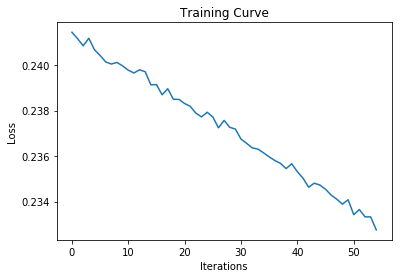

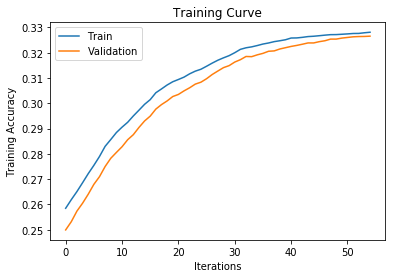

Final Training Accuracy: 0.3280862475198413
Final Validation Accuracy: 0.3265320888503003


In [0]:
#increasing batch size to lower training time
#increase num of epouchs to 
model = AutoEncoder()
tdl = torch.utils.data.DataLoader(trainn, batch_size=2048, shuffle=True)
vdl = torch.utils.data.DataLoader(val, batch_size=2048, shuffle=True)
train(model, tdl, vdl, num_epochs=5, learning_rate=1e-4)

#Final Training Accuracy: 0.3280862475198413
#Final Validation Accuracy: 0.3265320888503003
#increasing batch size without increasing num of epochs didn't give 
#enough iterations for the model to learn
#loss function decreases slightly from beginning to end

... ... ... ... ... ... ... ... ... ... ... | ... ... ... ... ... ... ... ... ... ... ... | ... ... ... ... ... ... ... ... ... ... ... | ... ... ... ... ... ... ... ... ... ... ... | ... ... ... ... ... ... ... ... ... ... ... | ... ... ... ... ... ... ... ... ... ... ... | ... ... ... ... ... ... ... ... ... ... ... | ... ... ... ... ... ... ... ... ... ... ... | ... ... ... ... ... ... ... ... ... ... ... | ... ... ... ... ... ... ... ... ... ... ... | 

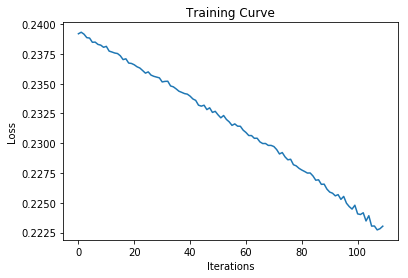

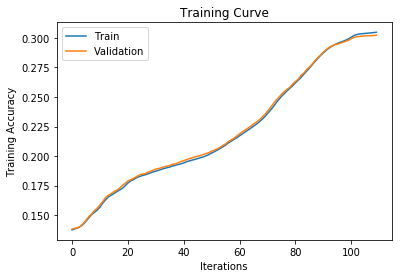

Final Training Accuracy: 0.3048192584325397
Final Validation Accuracy: 0.30232978800376237


In [0]:
#accuracy is continously increasing with time so allow for more training
#by increasing num of epouchs. Loss also continously going down but only dropped 0.008
#over training in comparison to original 0.2
#(aim for ~150)
#Final Training Accuracy: 0.22353980654761904
#Final Validation Accuracy: 0.22693726937269373

model = AutoEncoder()
batch_size=2048
train(model, tdl, vdl, num_epochs=10, learning_rate=1e-4)



... ... ... ... ... ... ... ... ... ... ... | ... ... ... ... ... ... ... ... ... ... ... | ... ... ... ... ... ... ... ... ... ... ... | ... ... ... ... ... ... ... ... ... ... ... | ... ... ... ... ... ... ... ... ... ... ... | ... ... ... ... ... ... ... ... ... ... ... | ... ... ... ... ... ... ... ... ... ... ... | ... ... ... ... ... ... ... ... ... ... ... | ... ... ... ... ... ... ... ... ... ... ... | ... ... ... ... ... ... ... ... ... ... ... | 

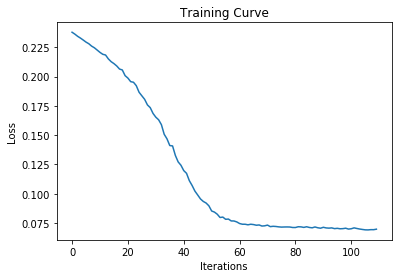

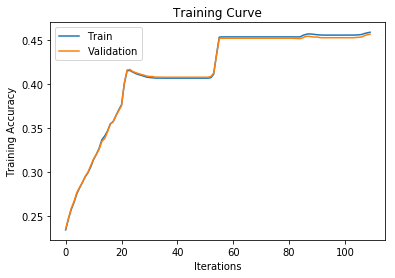

Final Training Accuracy: 0.4591858878968254
Final Validation Accuracy: 0.45694956949569493


In [0]:
#increaing num of epochs increased accuracy improved from 10% to 15%
#increasing learning rate to improve increased accuracy

      
#Final Training Accuracy: 0.4591858878968254
#Final Validation Accuracy: 0.45694956949569493
model = AutoEncoder()
tdl = torch.utils.data.DataLoader(trainn, batch_size=2048, shuffle=True)
vdl = torch.utils.data.DataLoader(val, batch_size=2048, shuffle=True)
train(model, tdl, vdl, num_epochs=10, learning_rate=1e-3)

#training minimized after 60 iterations.
#loss training curve too steep.


... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... | ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... | ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... | ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... | 

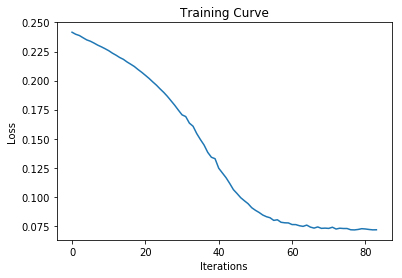

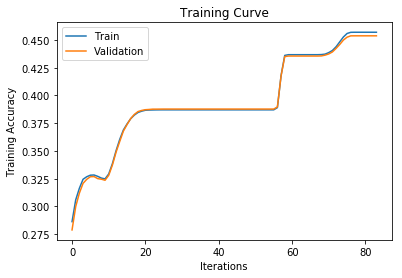

Final Training Accuracy: 0.45698474702380953
Final Validation Accuracy: 0.45376600824831775


In [0]:
#increaing num of epochs increased accuracy improved from 10% to 15%
#increasing learning rate to improve increased accuracy

#lower batch size 
#lower num of epochs to have similar number of iterations (time reasoning)
#increase learning rate -> in training accuracy increased by 0.15

model = AutoEncoder()
tdl = torch.utils.data.DataLoader(trainn, batch_size=1024, shuffle=True)
vdl = torch.utils.data.DataLoader(val, batch_size=1024, shuffle=True)
train(model, tdl, vdl, num_epochs=4, learning_rate=1e-3)

#Final Training Accuracy: 0.45698474702380953
#Final Validation Accuracy: 0.45376600824831775
#number of interations to platuee in loss training curve increased, longer time learning
#little change in accuracy

... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... | ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... | ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... | ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... | ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... | ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... | ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... | ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... | ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... | ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... | ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... | ... ... ... ... ... ... ... ... ... ... ... ... ... ..

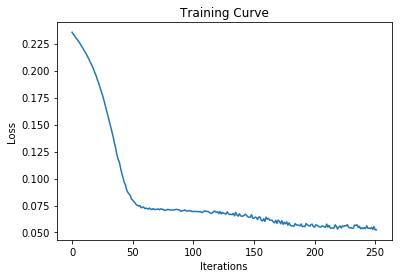

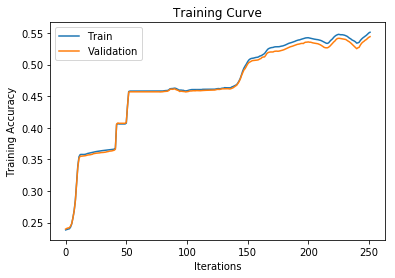

Final Training Accuracy: 0.5511842757936508
Final Validation Accuracy: 0.544208089139715


In [0]:
#run longer
model = AutoEncoder()
tdl = torch.utils.data.DataLoader(trainn, batch_size=1024, shuffle=True)
vdl = torch.utils.data.DataLoader(val, batch_size=1024, shuffle=True)
train(model, tdl, vdl, num_epochs=12, learning_rate=1e-3)
#Final Training Accuracy: 0.5511842757936508
#Final Validation Accuracy: 0.544208089139715

#running the model longer improved the accuracy, the method of training the model
#is still effective given more time. Loss function lowering. training accuracy
#curve jumps in accuracy are more spread out. 50 interation spread at 10 interations 
#to 150 spread after 50 interations. 

## Part 4. Testing [12 pt]

### Part (a) [2 pt]

Compute and report the test accuracy.

In [0]:
testdl = torch.utils.data.DataLoader(test, batch_size=1024, shuffle=True)
print("test accuracy: ", get_accuracy(model, testdl))

test accuracy:  0.5557846754938137


### Part (b) [4 pt]

Based on the test accuracy alone, it is difficult to assess whether our model
is actually performing well. We don't know whether a high accuracy is due to
the simplicity of the problem, or if a poor accuracy is a result of the inherent
difficulty of the problem.

It is therefore very important to be able to compare our model to at least one
alternative. In particular, we consider a simple **baseline**
model that is not very computationally expensive. Our neural network
should at least outperform this baseline model. If our network is not much
better than the baseline, then it is not doing well.

For our data imputation problem, consider the following baseline model:
to predict a missing feature, the baseline model will look at the **most common value** of the feature in the training set. 

For example, if the feature "marriage" is missing, then this model's prediction will be the most common value for "marriage" in the training set, which happens to be "Married-civ-spouse".

What would be the test accuracy of this baseline model?

**Do not actually implement this baseline model. You should be able to compute the 
test accuracy by reasoning about how the basline model behaves.**

In [0]:
#The test accuracy would be the average percentage of the most common value being the value of a feature
#over a large set of data this estimation would be approached and be a maximum accuracy the baseline could achieve.

#use sum and pick out the index of each greatest value in a feature range by spliting output and 
#inputting into get_categorical_value

#divide the first 5 by n because they have continous values

#The first 5 continous values would require using an uncertaininty to justify correction
#choices. For this estimation only looked at 6/5 of the features in calculating
#the test accuracy with the one hot enocoded classifications.

merge=np.sum(trainn,0)
print(cat_index)
n=len(trainn)
temp=['work', 'marriage', 'occupation', 'edu', 'relationship', 'sex']
t1=[]
t2=[]
popular_feature=[]
merge=merge/n
for i in range(5):
  popular_feature.append(merge[i])
  
title=[]#titel of most common values
prop=[] #store probablity of most common value (one hot only)
for i in range(len(temp)):
  x=cat_index[temp[i]]
  y=len(cat_values[temp[i]])
  #print(x,y)
  #print(merge[x:x+y])
  m=merge[x:x+y]
  ind=np.where(m==np.amax(m))
  #print(ind[0][0])
  z=cat_values[temp[i]][ind[0][0]]
  title.append(z)
  prop.append(m[ind[0][0]]/np.sum(m))
print(popular_feature)
print(title)
print("How common each of the most common value (one hot only) are",prop)


print("testing accuracy estiamtion :", sum(prop)/len(prop))

#therefore 45.85%






{'work': 5, 'marriage': 12, 'occupation': 19, 'edu': 33, 'relationship': 49, 'sex': 55}
[0.2930006, 0.6093285, 0.011048789, 0.020513482, 0.40726453]
['Private', 'Married-civ-spouse', 'Prof-specialty', 'HS-grad', 'Husband', 'Male']
How common each of the most common value (one hot only) are [0.7426525, 0.46289062, 0.13509116, 0.3247303, 0.40992373, 0.6759208]
testing accuracy estiamtion : 0.4585348467032115


### Part (c) [1 pt]

How does your test accuracy from part (a) compared to your basline test accuracy in part (b)?

In [0]:
#55.57 a) to 45.85% b)
#~10% better

### Part (d) [1 pt]

Look at the first item in your test data. 
Do you think it is reasonable for a human
to be able to guess this person's education level
based on their other features? Explain.

In [0]:
#recreate get_accuracy random emptying of one feature



for item in testdl: # minibatches
       print("edu before 0'd out: ",item.detach().numpy()[0][33:48])
       x=zero_out_feature(item.clone(), "edu")
       break


print("edu after 0'd out :",x.detach().numpy()[0][33:48])

print("test case: ",x.detach().numpy()[0])
df[:3]


#with information displayed with panda, a person can guess the education level
#for example iwth df[0] with with the age being 0.3 (meaning between 17 and 78)
#the person is around 30. also never marred, occupation of adm-clerical and male.
#using bias people would be able to use information they've collected in their lives
# to assume the education level of this person.


edu before 0'd out:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
edu after 0'd out : [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
test case:  [0.30136988 0.53333336 0.         0.         0.4489796  0.
 0.         1.         0.         0.         0.         0.
 0.         0.         1.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         1.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         1.         0.         0.         0.         0.
 0.         0.         1.        ]


,age,yredu,capgain,caploss,workhr,work,marriage,occupation,edu,relationship,sex
0,0.301370,0.800000,0.02174,0.0,0.397959,State-gov,Never-married,Adm-clerical,Bachelors,Not-in-family,Male
1,0.452055,0.800000,0.00000,0.0,0.122449,Self-emp-not-inc,Married-civ-spouse,Exec-managerial,Bachelors,Husband,Male
2,0.287671,0.533333,0.00000,0.0,0.397959,Private,Divorced,Handlers-cleaners,HS-grad,Not-in-family,Male


### Part (e) [2 pt]

What is your model's prediction of this person's education
level, given their other features?


In [0]:
output= model(x).detach().numpy()
print(output[0])
zz=output[0][33:48]
print(zz)
print(np.amax(zz))
ind=np.where(zz==np.amax(zz))[0][0]
print(ind)
print(cat_values["edu"][11])
#My model predicted the person was a hs-grad

[0.31243473 0.6324662  0.00594048 0.01103679 0.44661796 0.01647902
 0.07101594 0.7161312  0.00425451 0.1133352  0.02168867 0.00759723
 0.03156086 0.00392606 0.95976466 0.01149749 0.07445091 0.01786044
 0.00368849 0.02339892 0.0021885  0.18017574 0.1474253  0.01444072
 0.00823526 0.00639746 0.02113109 0.00680094 0.11029044 0.00905846
 0.09366754 0.01373739 0.01268372 0.01339521 0.00331806 0.00965883
 0.00338666 0.00921711 0.01816329 0.00976046 0.02177169 0.01521331
 0.15978096 0.02565191 0.32145125 0.04090612 0.00295213 0.0086539
 0.1603212  0.9490576  0.05822798 0.00554621 0.0481644  0.04283664
 0.01869353 0.00335518 0.9969342 ]
[0.01339521 0.00331806 0.00965883 0.00338666 0.00921711 0.01816329
 0.00976046 0.02177169 0.01521331 0.15978096 0.02565191 0.32145125
 0.04090612 0.00295213 0.0086539 ]
0.32145125
11
HS-grad


### Part (f) [2 pt]

What is the baseline model's prediction
of this person's education level?

In [0]:
#index 4th of most common values (one hot) is for edu
print(title[3])
#the baseline predicted that was a hs grad

HS-grad
